# Mapping chemically peculiar stars

In this notebook, we generate a synthetic light curve of an inclined star whose surface is described by a simple isotropic gaussian power spectrum. Given the light curve and (precise) knowledge of the map's power spectrum, we attempt to infer the inclination and orbital period of the star by marginalizing over all maps.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
import theano.tensor as tt

## Generate the dataset

Generate a 10th degree spherical harmonic map sampled from an isotropic gaussian power spectrum and compute its light curve:

In [4]:
# True values
truths = {
    "inc":      60.0,
    "period":   8.53,
    "ydeg":     10,
    "p_amp":    0.002,
    "p_sig":    3.0,
    "flux_err": 0.001
}

# Generate a power spectrum
truths["power"] = np.array([truths["p_amp"] * np.exp(-0.5 * (l / truths["p_sig"]) ** 2) 
                            for l in range(1, truths["ydeg"] + 1) for m in range(-l, l + 1)])

# Draw a map from this spectrum
np.random.seed(43)
truths["y"] = np.random.randn((truths["ydeg"] + 1) ** 2 - 1) * np.sqrt(truths["power"])

# Generate a synthetic dataset
t = np.linspace(0, 27, 500)
map = starry.Map(ydeg=truths["ydeg"])
map[1:, :] = truths["y"]
map.inc = truths["inc"]
theta = 360. * t / truths["period"]

# Compute the design matrix and dot `y` in to get the flux
# Recall that the y[0] term is *fixed* at unity, so we need
# to treat it separately by breaking up the design matrix:
#     flux = (X_0 . 1) + (X_1: . y)
X = map.X(theta=theta)
truths["flux"] = (X[:, 0] + np.dot(X[:, 1:], truths["y"]))

# Convert to ppt for numerics
truths["flux"] = (truths["flux"] - 1) * 1e3
truths["flux_err"] *= 1e3
truths["y"] *= 1e3
truths["power"] *= 1e6

# Add noise
np.random.seed(44)
flux = truths["flux"] + truths["flux_err"] * np.random.randn(len(t))

Here's what the star looks like on the plane of the sky:

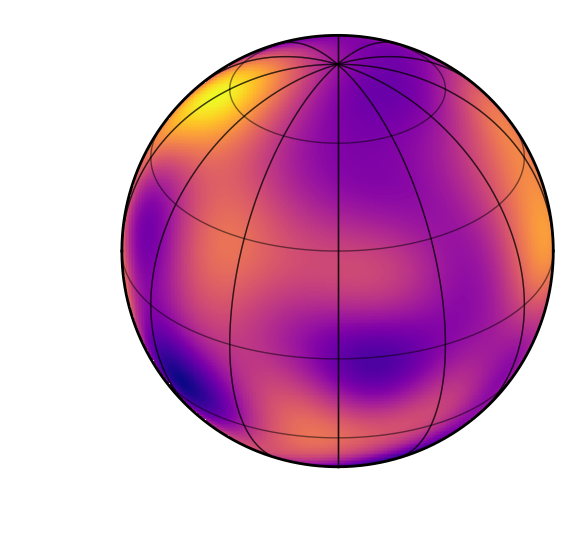

In [5]:
map.show()

Here's a rectangular latitude-longitude view of the map:

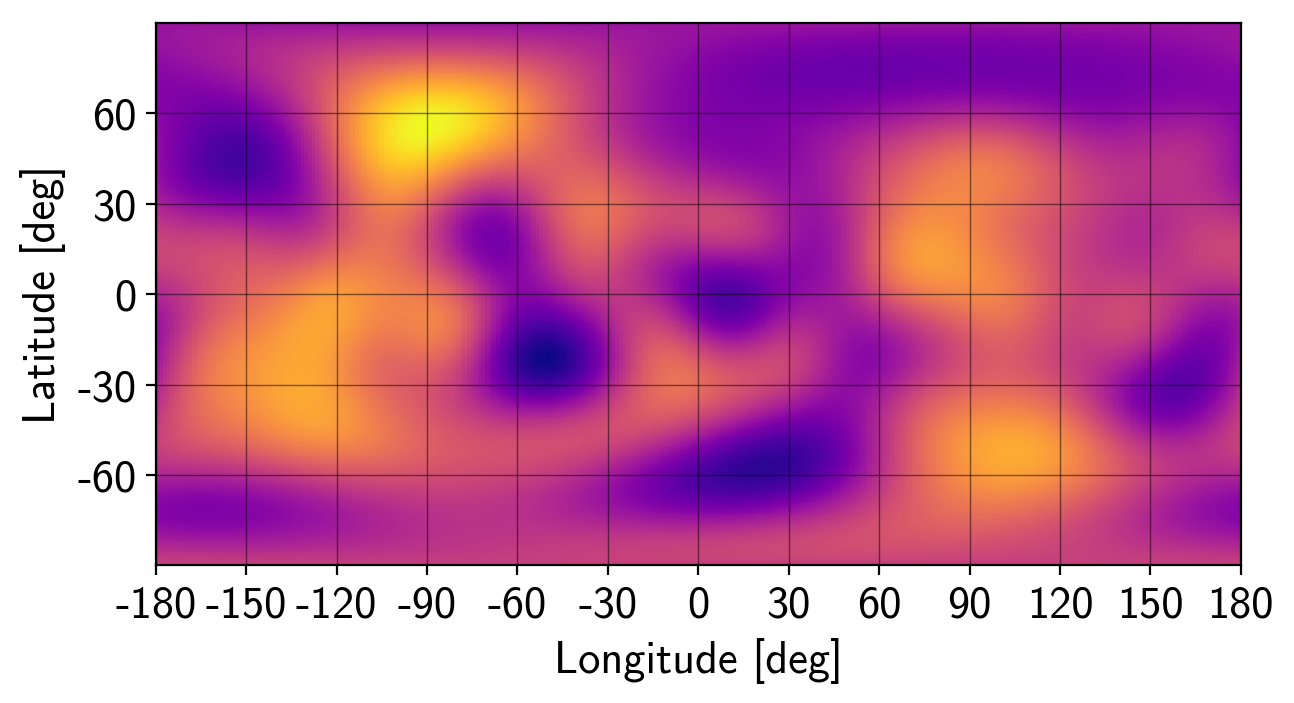

In [6]:
map.show(projection="rect")

And this is the observed light curve over ~3 rotations:

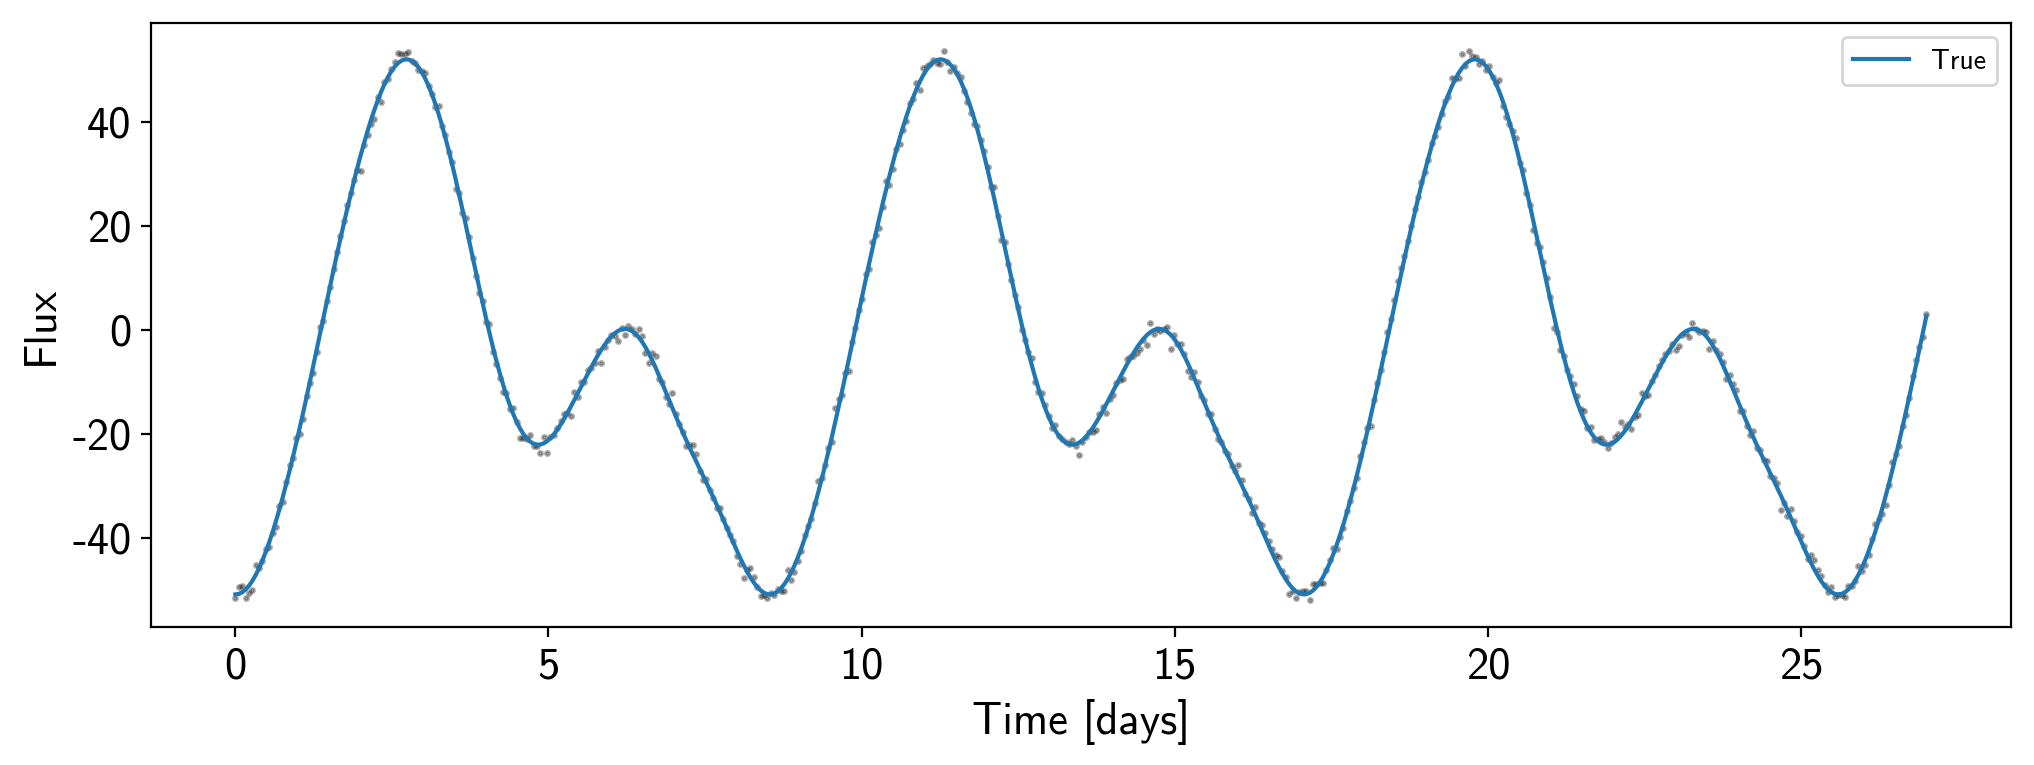

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

## Inference

Define our `PyMC3` model using `starry`. At every step of the chain, we (analytically) solve the least squares problem for the maximum likelihood spherical harmonic coefficients of the map, given the period, inclination, and map power spectrum. The likelihood of the proposal is the likelihood of this best-fit solution plus a correction term that marginalizes over all possible maps.

In [8]:
map = starry.Map(ydeg=truths["ydeg"])
with pm.Model() as model:

    # Priors on the things we're solving for
    period = pm.Uniform("period", 8.4, 8.6)
    inc = pm.Uniform("inc", 50, 90)
     
    # Compute the model using starry
    theta = 360.0 * t / period
    XFull = map.X(theta=theta, inc=inc)
    X0 = XFull[:, 0]
    X = XFull[:, 1:]
    
    # Solve the least squares problem
    XT = X.T / truths["flux_err"] ** 2
    XTX = tt.dot(XT, X)
    LInv = tt.diag(1.0 / truths["power"])
    W = XTX + LInv
    XTf = tt.dot(XT, flux)
    
    # Cholesky decomposition
    cho_W = tt.slinalg.cholesky(W)
    Q = tt.slinalg.solve_lower_triangular(cho_W, XTf)
    y = tt.slinalg.solve_upper_triangular(cho_W.T, Q)
    
    # Get the MAP flux model
    flux_model = tt.dot(X, y)
    
    # L2 penalty on `y`
    pm.Normal("L2", mu=0, sd=np.sqrt(truths["power"]), observed=y)
    
    # Correction for marginal likelihood
    pm.Potential("marginal", -tt.sum(tt.log(tt.diag(cho_W))))
    
    # Track some values for plotting later
    pm.Deterministic("y", y)

    # Save our initial guess
    model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=truths["flux_err"], observed=flux)

In [9]:
with model:
    map_soln = xo.optimize()

optimizing logp for variables: ['inc_interval__', 'period_interval__']
message: Optimization terminated successfully.
logp: -1090.617273567997 -> -877.2928681173107


In [ ]:
# Timing test
with model:
    func = xo.get_theano_function_for_var(model.logpt)
    grad = xo.get_theano_function_for_var(theano.grad(model.logpt, model.vars))
    vars = xo.get_args_for_theano_function()
    func(*vars)
    grad(*vars)
    %timeit func(*vars)
    %timeit grad(*vars)
    pfunc = xo.get_theano_function_for_var(model.logpt, profile=True)
    pfunc(*vars)
    pgrad = xo.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    pgrad(*vars)
    pfunc.profile.summary()
    pgrad.profile.summary()

map_soln

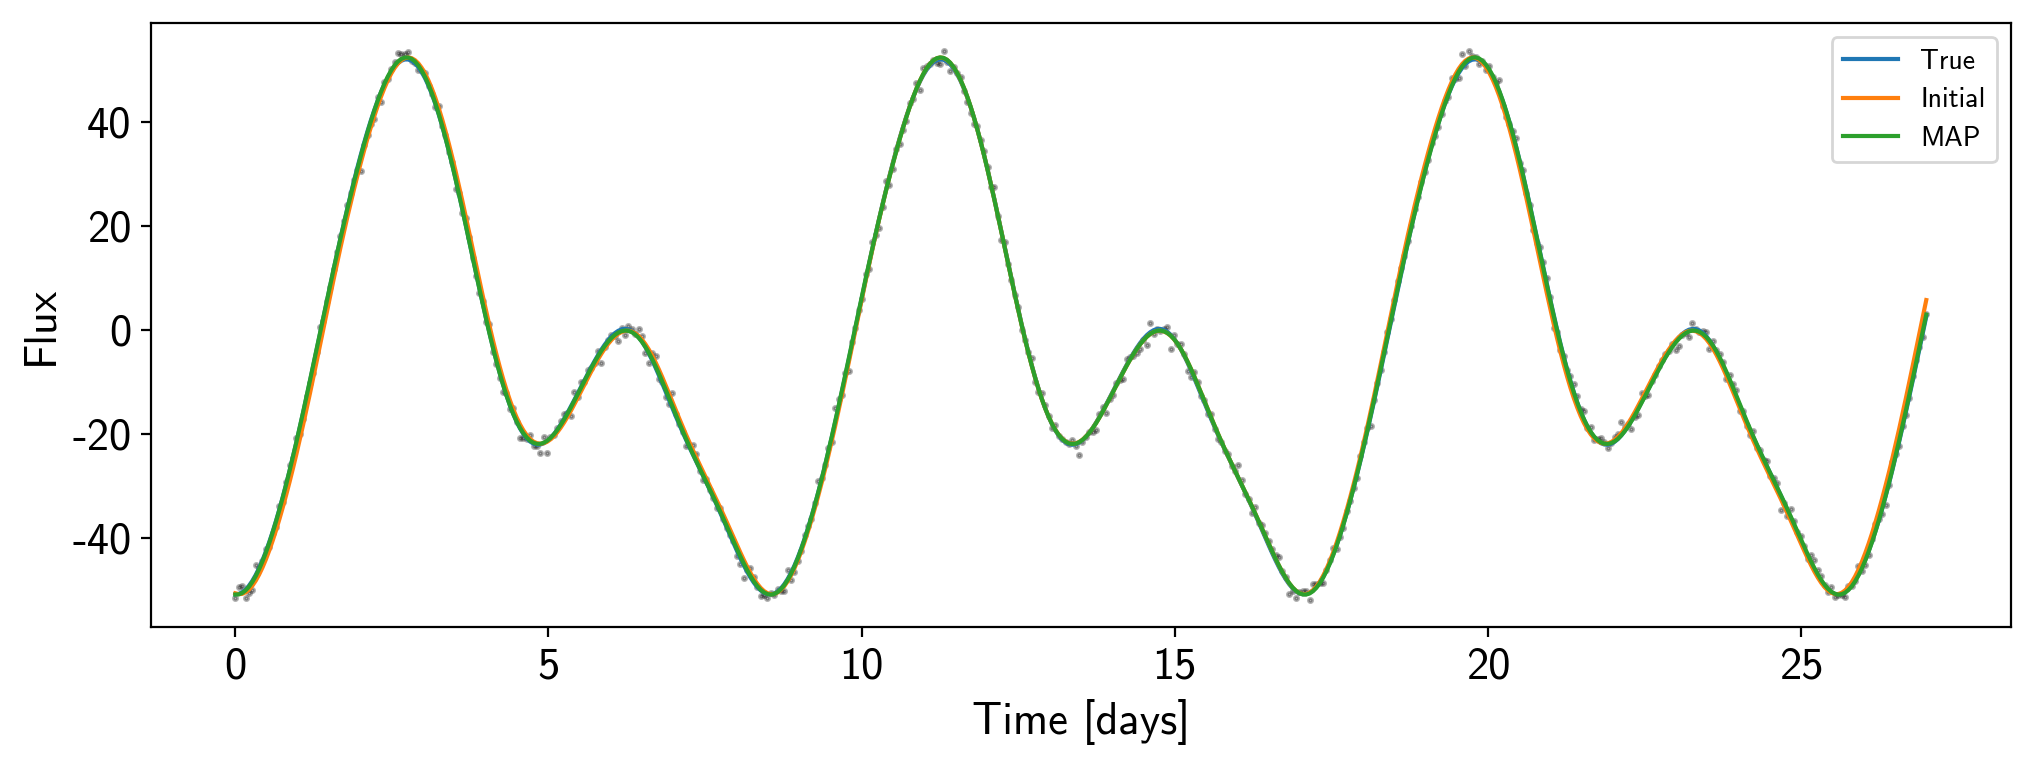

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.plot(t, xo.eval_in_model(flux_model, map_soln, model=model), label="MAP")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

Now we sample the posterior. (Check out [this issue](https://github.com/Theano/Theano/issues/6667) for details on the warning we're getting.)

In [ ]:
sampler = xo.PyMC3Sampler(window=100, finish=200, cores=1)
with model:
    burnin = sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Visualize the results:

In [ ]:
varnames = ["period", "inc"]
pm.summary(trace, varnames=varnames)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples, truths=[truths["period"], truths["inc"]]);

In [ ]:
for i in range(3):
    j = np.random.randint(len(trace["y"]))
    map[1:, :] = trace["y"][j]
    map.show(projection="rect")